# Exploratory data analysis | Explorative Datenanalyse

## Feuerwehreinsätze Stadt und Landkreis Schweinfurt (SW)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap
import warnings

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

### Daten laden und erster Blick

In [2]:
df = pd.read_csv("./Dataset/einsätze_erweitert.csv")
df.shape

(15440, 24)

In [3]:
df.head(1)

,Nr,Alarmierungszeit,Wochentag,Einsatztyp,Einsatzort,Link_einsatz,Bild,Kurzbericht,Organisationen,Content,...,Monat,Tag,Stunde,Minute,Kalenderwoche,Jahrestag,Adresse_Einsatzort,Koordinaten_Einsatzort,Längengrad,Breitengrad
0,1352,2022-12-31 21:55:00,Saturday,Brand,Heidenfeld,/index.php/einsaetze/einsatzbericht/40822,nopic.png,Brand am Gebäude,FF Gochsheim;FL Schweinfurt-Land 4/4;FF Röthle...,"<tr class=""row0"">\n<td class=""mobile_hide_480 ...",...,12,31,21,55,52,365,"Germany, Bavaria, Schweinfurt, Heidenfeld","Heidenfeld, Röthlein, Landkreis Schweinfurt, B...",10.206644,49.967824


Die Spalte Nr starte jedes Jahr von 1 an, es ist also durch die Nr keine exakte Zuordnung möglich.
Wenn die Alarmierungszeiten zweier Einsätze, auf die Minute genau gleich ist, erhalten diese die gleiche Nr.

In [4]:
# Anzahl an unique Werten pro Spalte
df.nunique()

Nr                         1607
Alarmierungszeit          15009
Wochentag                     7
Einsatztyp                    7
Einsatzort                  875
Link_einsatz              15440
Bild                       1004
Kurzbericht                4490
Organisationen             2760
Content                   15440
Text                      15276
Organisationen_Liste       2761
Organisationen_Anzahl        27
Jahr                         22
Monat                        12
Tag                          31
Stunde                       24
Minute                       60
Kalenderwoche                53
Jahrestag                   366
Adresse_Einsatzort          875
Koordinaten_Einsatzort      264
Längengrad                  264
Breitengrad                 264
dtype: int64

### Daten säubern und vorbereiten

In [5]:
# Doppelte Einträge löschen wenn Nr, Alarmierungszeit, Wochentag, Einsatztyp, Einsatzort, 
# Link_einsatz, Bild, Kurzbericht und Organisationen gleich sind
# Sollte eigentlich keine doppelten Einträge geben
df = df.drop_duplicates(subset = ["Nr", "Alarmierungszeit", "Wochentag", "Einsatztyp", "Einsatzort", 
                                  "Link_einsatz", "Bild", "Kurzbericht", "Organisationen"])
df.shape

(15440, 24)

In [6]:
# Spalte Organisationen_Liste als Liste interpretieren
df["Organisationen_Liste"] = df["Organisationen"].apply(lambda x: str(x).split(";"))

## Analyse

### Einsätze nach Alamierungszeit

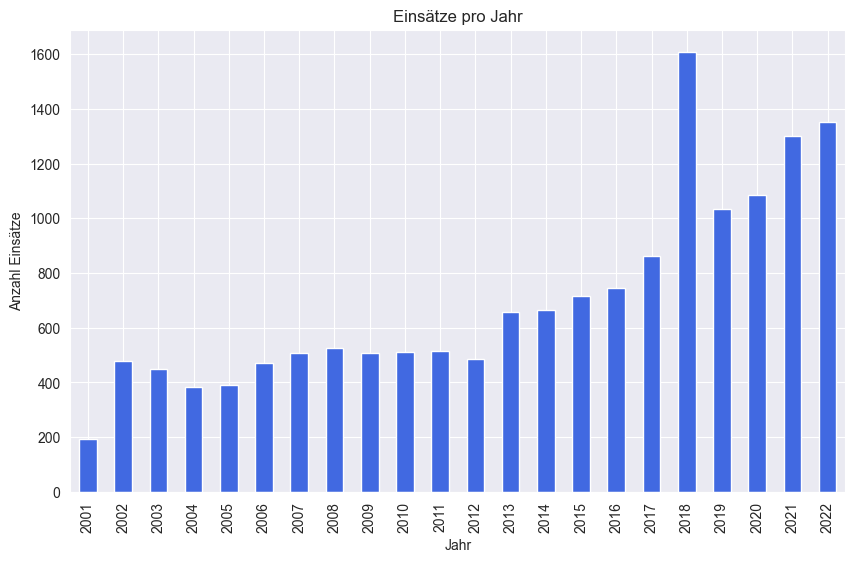

In [7]:
color = "royalblue" # Farbe für die Plots

# Summe der Einsätze pro Jahr, sortiert nach Jahr, mit Titel und Labels
plt.figure(figsize=(10, 6))
plt.title("Einsätze pro Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl Einsätze")
df["Jahr"].value_counts().sort_index().plot(kind="bar", color=color)
plt.savefig("./Plots/einsaetze_pro_jahr.png")

- 2001: Start der Daten im Mai
- 2018: deutlich mehr Einsätze als jedes andere Jahr, wird später genauer betrachtet
- Trend klar erkennbar, die Einsätze pro Jahr steigen an

Tableau

![Einsätze](./Plots/Tableau/einsaetze_pro_jahr.png "Einsätze pro Jahr")

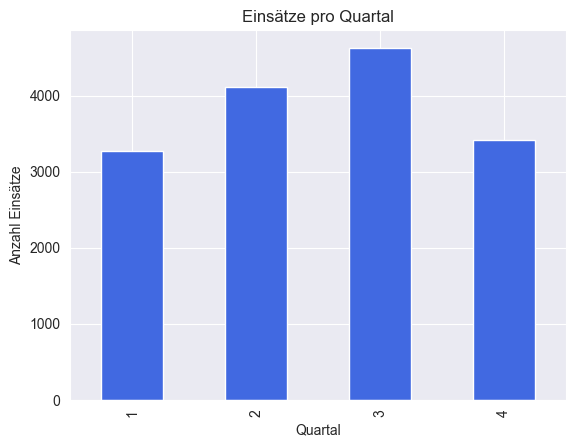

In [8]:
# Plot Summe der Einsätze pro Quartal, aus Alarmierungszeit, sortiert nach Quartal, mit Titel und Labels
plt.title("Einsätze pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Anzahl Einsätze")
pd.to_datetime(df["Alarmierungszeit"]).dt.quarter.value_counts().sort_index().plot(kind="bar", color=color)
plt.savefig("./Plots/einsaetze_pro_quartal.png")

- In Quartal 3 am meisten Einsätze

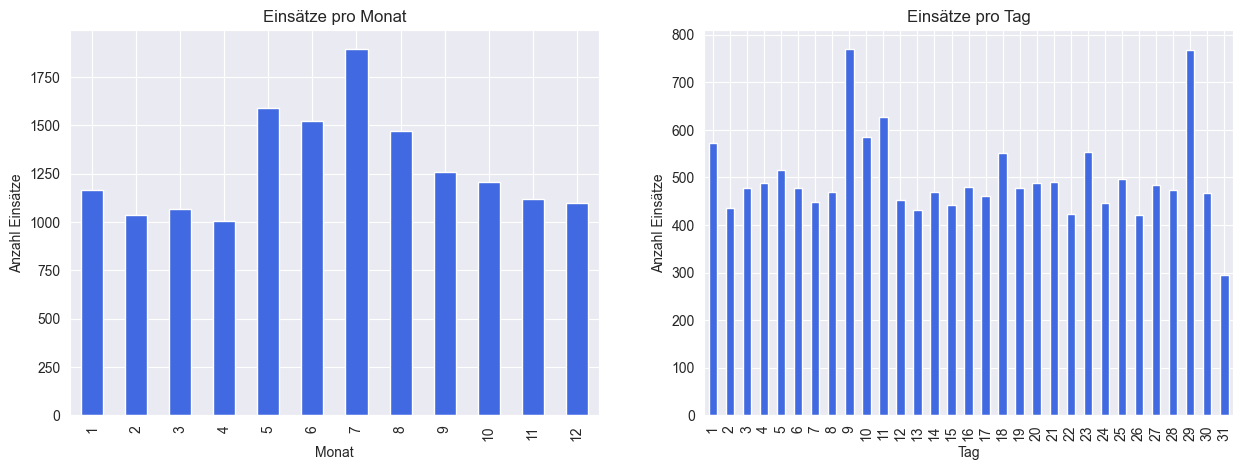

In [9]:
# Plot mit zwei Subplots
# 1. Summe der Einsätze pro Monat, sortiert nach Monat, mit Titel und Labels
# 2. Summe der Einsätze pro Tag, sortiert nach Tag, mit Titel und Labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Einsätze pro Monat")
ax1.set_xlabel("Monat")
ax1.set_ylabel("Anzahl Einsätze")
df["Monat"].value_counts().sort_index().plot(kind="bar", ax=ax1, color=color)

ax2.set_title("Einsätze pro Tag")
ax2.set_xlabel("Tag")
ax2.set_ylabel("Anzahl Einsätze")
df["Tag"].value_counts().sort_index().plot(kind="bar", ax=ax2, color=color)
plt.savefig("./Plots/einsaetze_pro_monat_und_tag.png")

- Saisonalität bei den Monaten erkennbar, im Sommer mehr als im Winter
- Einsätze pro Tag: 
  - Tag 9 und Tag 29 stechen klar raus
  - Tag 31 deutlich gerninger, da nicht jeder Monat 31 Tage hat

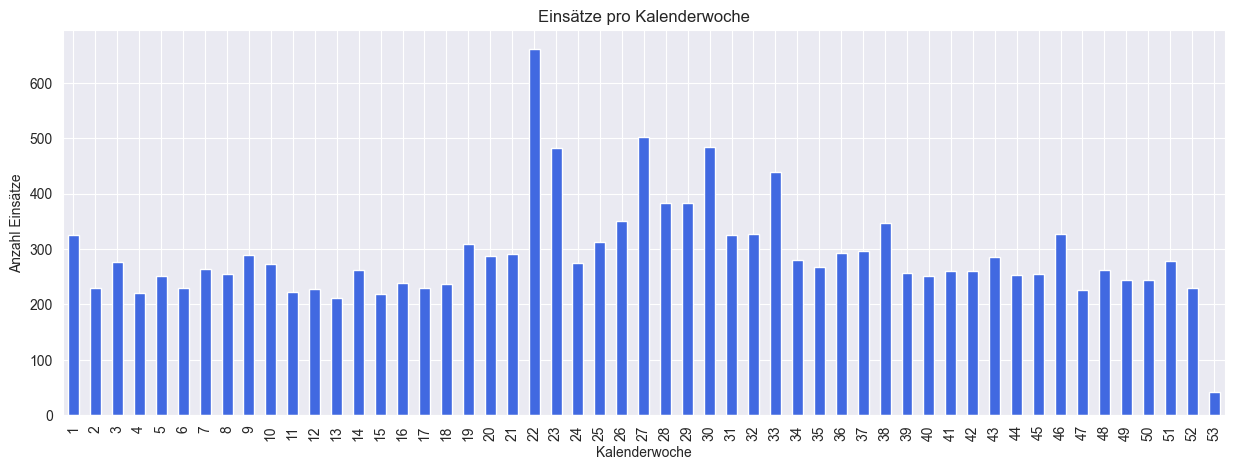

In [10]:
# Plot Summe der Einsätze pro Kalenderwoche
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Kalenderwoche")
plt.xlabel("Kalenderwoche")
plt.ylabel("Anzahl Einsätze")
df["Kalenderwoche"].value_counts().sort_index().plot(kind="bar", color=color)
plt.savefig("./Plots/einsaetze_pro_kalenderwoche.png")

- Im Sommer leicht mehr Einsätze als im Winter
- Ausreißer bei KW 22
- KW 53 sehr gering, da KW53 nicht in jedem Jahr vorkommt

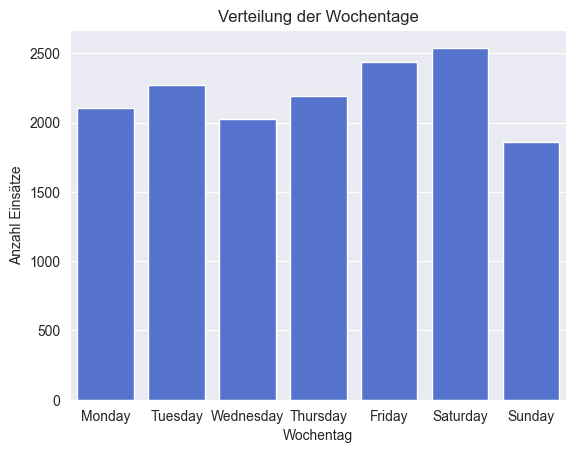

In [11]:
# Plot Verteilung der Wochentage, sortiert von Monday bis Sunday, mit Titel
plt.title("Verteilung der Wochentage")
sns.countplot(x="Wochentag", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], color=color)
plt.ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_wochentage.png")

- Relativ gleichverteilt über die Wochentage
- Samstag am höchsten
- Sonntag am geringsten

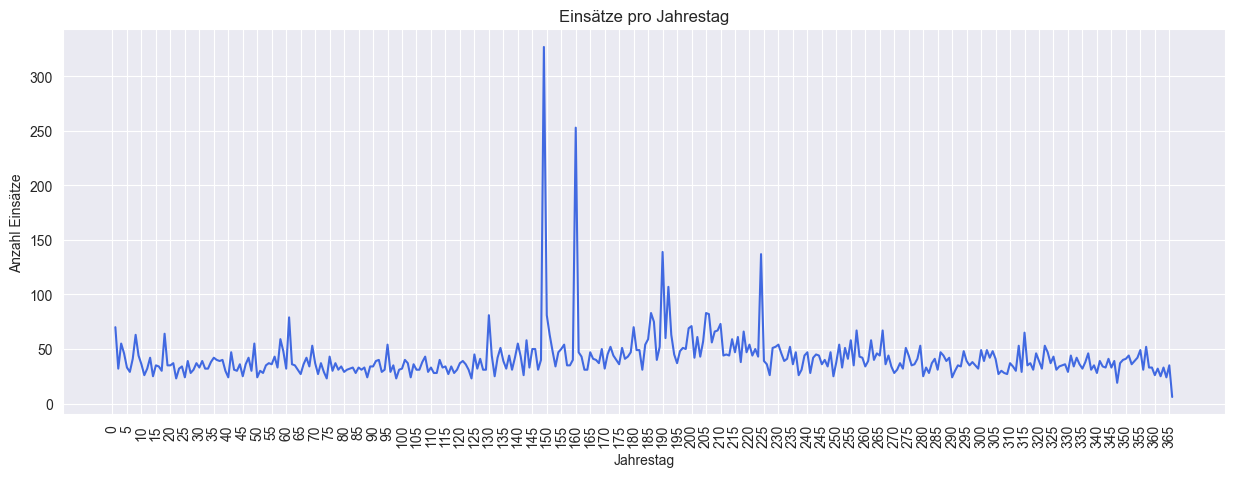

In [12]:
# Plot Summe der Einsätze pro Jahrestag, nur jedes fünfte x-Label anzeigen
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Jahrestag")
plt.xlabel("Jahrestag")
plt.ylabel("Anzahl Einsätze")
df["Jahrestag"].value_counts().sort_index().plot(kind="line", color=color)
plt.xticks(np.arange(0, 366, 5), rotation=90)
plt.savefig("./Plots/einsaetze_pro_jahrestag.png")

In [13]:
# Top 5 pro Jahrestag
df["Jahrestag"].value_counts().sort_values(ascending=False).head(5)

149    327
160    253
190    139
224    137
192    107
Name: Jahrestag, dtype: int64

- Saisonalität bei den Jahreszeiten erkennbar
  - Sommer am höchsten
  - Frühling und Herbst am geringsten
  - Winter im Mittelfeld
- Zwei deutliche Ausreißer
  - Tag 149
  - Tag 160
- Zwei leichte Ausreißer
  - Tag 190
  - Tag 137
- Sonst relativ gleich verteilt, aber Rauschen ist deutlich zu erkennen

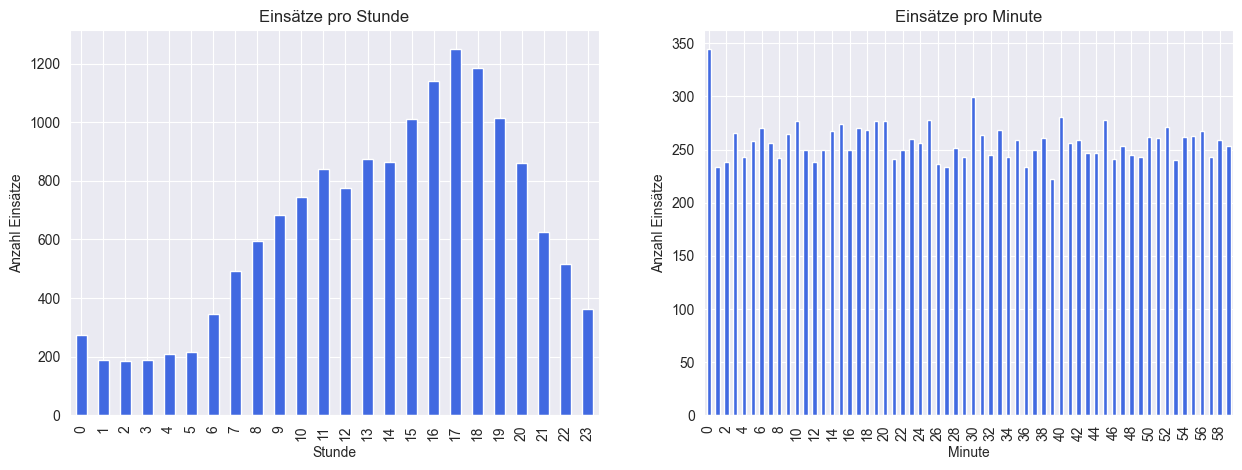

In [14]:
# Plot mit zwei subplots
# 1. Summe der Einsätze pro Stunde, sortiert nach Stunde, mit Titel und Labels
# 2. Summe der Einsätze pro Minute, sortiert nach Minute, nur jedes zweite x-Label, mit Titel und Labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Einsätze pro Stunde")
ax1.set_xlabel("Stunde")
ax1.set_ylabel("Anzahl Einsätze")
df["Stunde"].value_counts().sort_index().plot(kind="bar", ax=ax1, color=color)

ax2.set_title("Einsätze pro Minute")
ax2.set_xlabel("Minute")
ax2.set_ylabel("Anzahl Einsätze")
df["Minute"].value_counts().sort_index().plot(kind="bar", ax=ax2, color=color)
ax2.set_xticks(np.arange(0, 60, 2))
plt.savefig("./Plots/einsaetze_pro_stunde_und_minute.png")

- Saisonalität bei den Stunden, steigt bis Nachmittag / Abends an und nimmt anschließend wieder ab
- Minuten relativ gleich verteilt, einziger Ausreißer bei Minute 0

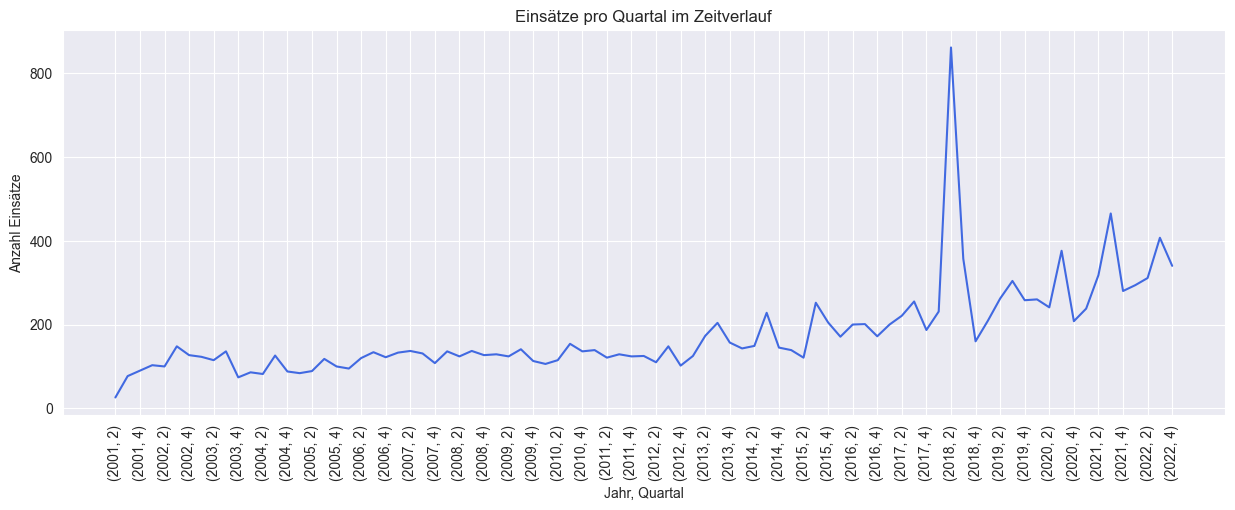

In [15]:
# Plot Anzahl der Einsätze für jedes Quartal pro Jahr im Zeitverlauf
jahr_quartal = df.groupby(["Jahr", pd.to_datetime(df["Alarmierungszeit"]).dt.quarter])["Nr"].count()
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Quartal im Zeitverlauf")
jahr_quartal.plot(color=color)
plt.xticks(np.arange(0, len(jahr_quartal), 2), jahr_quartal.index[::2], rotation=90)
plt.xlabel("Jahr, Quartal")
plt.ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_quartal_im_zeitverlauf.png")

- Der steigende Trend ist auch hier deutlich zu erkennen
- Der Ausreißer bei 2018 ist auch hier sichtbar

In [16]:
# Summe der Einsätze für jeden Monat aller Jahre und speichere in neuem DataFrame
df_einsätze_monat = df.groupby(["Jahr", "Monat"])["Nr"].count().reset_index(name="Anzahl")

# erzeuge ein Label aus Jahr und Monat
df_einsätze_monat["Jahr_Monat"] = df_einsätze_monat["Jahr"].astype(str) + "-" + df_einsätze_monat["Monat"].astype(str).str.zfill(2)

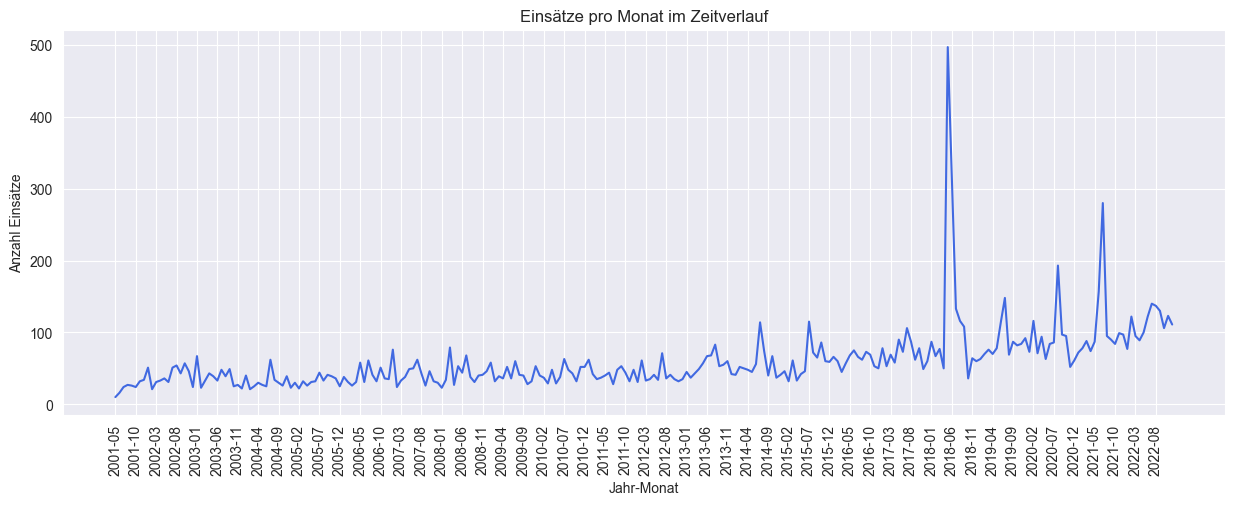

In [17]:
# Plot Anzahl als Linechart für alle Jahr_Monat, mit Titel und Labels, x-Achse als Jahr_Monat um 90° drehen, nur jedes 5. Label anzeigen
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Monat im Zeitverlauf")
plt.xlabel("Jahr-Monat")
plt.ylabel("Anzahl Einsätze")
plt.xticks(np.arange(0, len(df_einsätze_monat["Jahr_Monat"]), 5), rotation=90)
plt.plot(df_einsätze_monat["Jahr_Monat"], df_einsätze_monat["Anzahl"], color=color)
plt.savefig("./Plots/einsaetze_pro_monat_im_zeitverlauf.png")

- Ausreißer
  - 2018
  - 2020
  - 2021
- Steigender Trend auch hier leicht erkennbar
- Mehr Schwankungen als bei Quartal

In [18]:
# Moving Mean
df_einsätze_monat["Moving_Mean_3"] = df_einsätze_monat["Anzahl"].rolling(3).mean()      # Quartal
df_einsätze_monat["Moving_Mean_12"] = df_einsätze_monat["Anzahl"].rolling(12).mean()    # Jahr

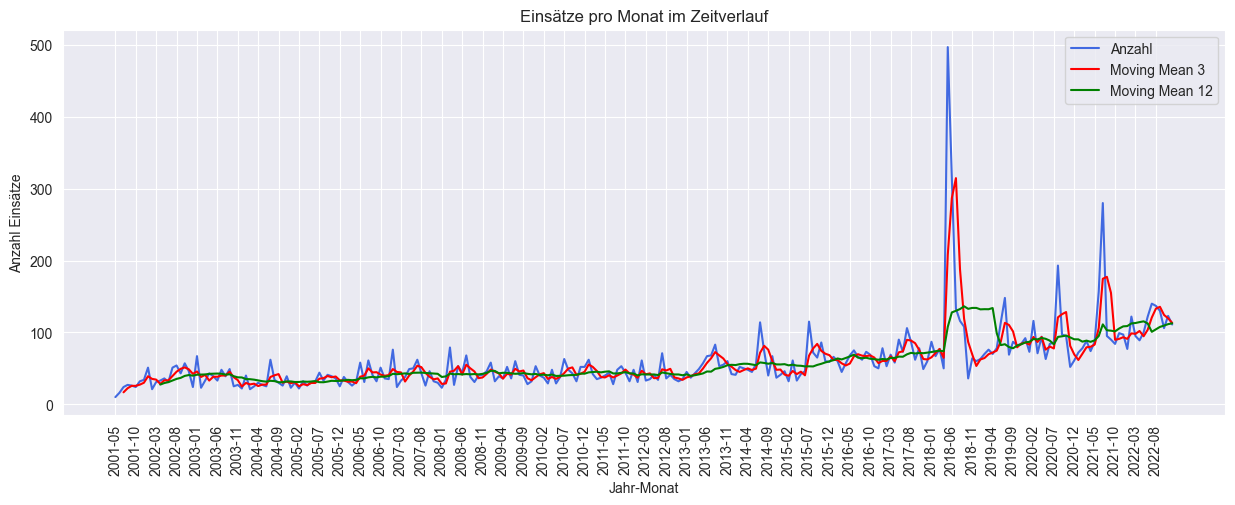

In [19]:
# Plot Anzahl und Moving Mean
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Monat im Zeitverlauf")
plt.xlabel("Jahr-Monat")
plt.ylabel("Anzahl Einsätze")
plt.xticks(np.arange(0, len(df_einsätze_monat["Jahr_Monat"]), 5), rotation=90)
plt.plot(df_einsätze_monat["Jahr_Monat"], df_einsätze_monat["Anzahl"], color=color, label="Anzahl")
plt.plot(df_einsätze_monat["Jahr_Monat"], df_einsätze_monat["Moving_Mean_3"], color="red", label="Moving Mean 3")
plt.plot(df_einsätze_monat["Jahr_Monat"], df_einsätze_monat["Moving_Mean_12"], color="green", label="Moving Mean 12")
plt.legend()
plt.savefig("./Plots/einsaetze_pro_monat_im_zeitverlauf_moving_mean.png")

- Moving Mean 3 Monate
  - Die Schwankungen sind deutlich geringer
  - Die Ausreißer sind hier noch deutlich zu erkennen
  - Die Saisionalität ist noch erkennbar
- Moving Mean 12 Monate
  - Die Schankungen sind noch geringer
  - Die Ausreißer sind bis auf 2018 nicht mehr zu erkennen
  - Die Saisonalität ist komplett geglättet

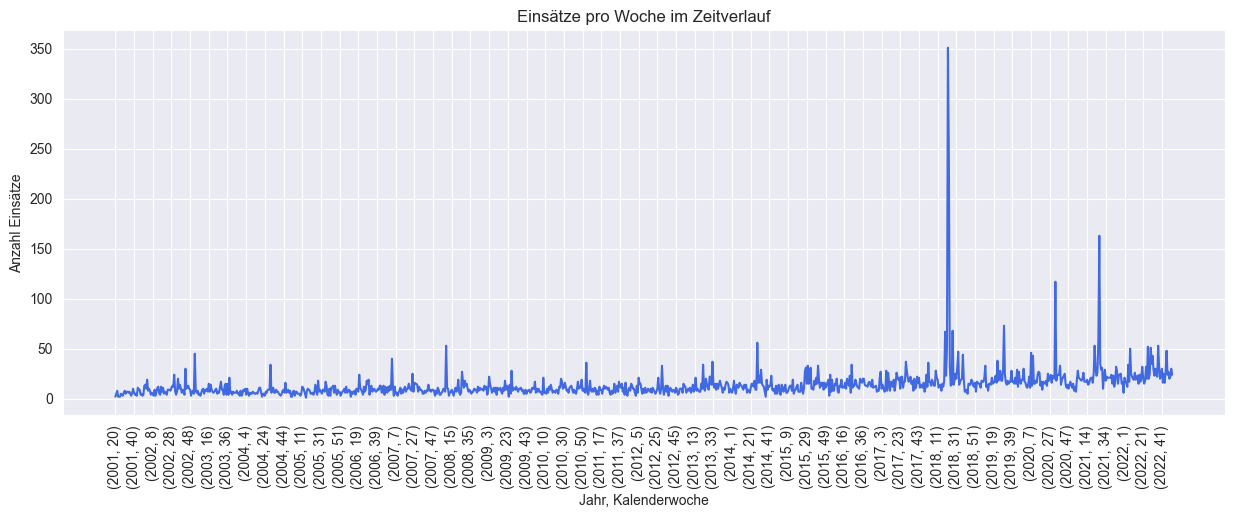

In [20]:
# Plot Anzahl Einsätze pro Woche im Zeitverlauf
jahr_woche = df.groupby(["Jahr", "Kalenderwoche"])["Nr"].count()
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Woche im Zeitverlauf")
jahr_woche.plot(color=color)
plt.xticks(np.arange(0, len(jahr_woche), 20), jahr_woche.index[::20], rotation=90)
plt.xlabel("Jahr, Kalenderwoche")
plt.ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_woche_im_zeitverlauf.png")

- Gleichen Besonderheiten, wie bei den Monaten zuvor
- Mehr Schwankungen als bei Monat

In [21]:
# Neuer DataFrame mit Summe der Einsätze für jeden Tag aller Jahre
df_einsätze_tag = df.groupby(["Jahr", "Monat", "Tag"])["Nr"].count().reset_index(name="Anzahl")

# Erzeuge ein Label aus Jahr, Monat und Tag
df_einsätze_tag["Jahr_Monat_Tag"] = df_einsätze_tag["Jahr"].astype(str) + "-" + \
                                    df_einsätze_tag["Monat"].astype(str).str.zfill(2) + "-" + \
                                    df_einsätze_tag["Tag"].astype(str).str.zfill(2)

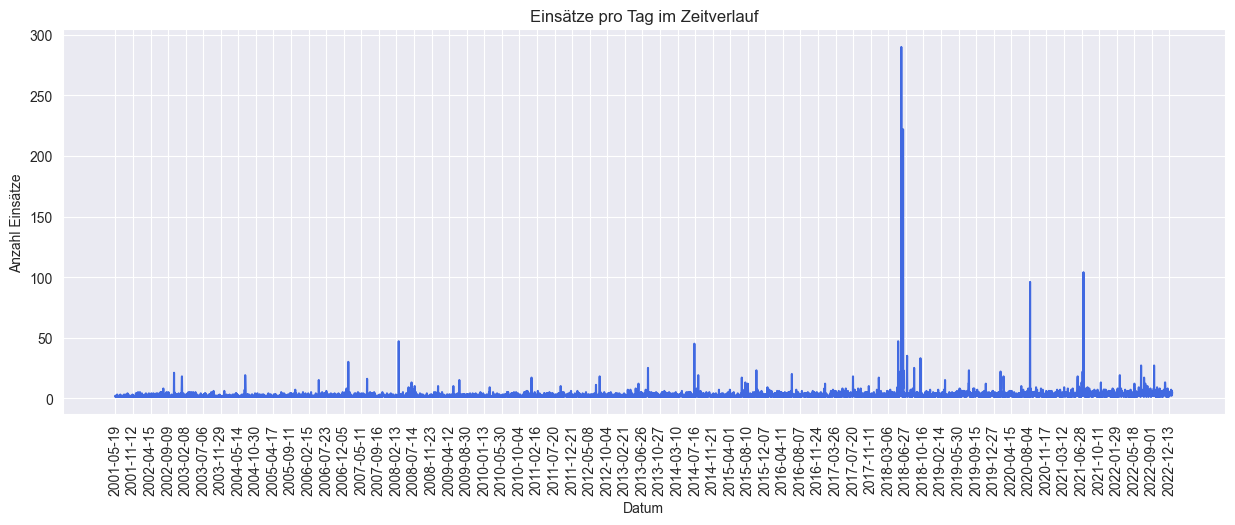

In [22]:
# Plot Anzahl Einsätze pro Tag als Linechart, mit Titel und Labels, x-Achse als Jahr_Monat_Tag um 90° drehen, nur jedes 100. Label anzeigen
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Tag im Zeitverlauf")
plt.xlabel("Datum")
plt.ylabel("Anzahl Einsätze")
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(df_einsätze_tag["Jahr_Monat_Tag"]), 100))
plt.plot(df_einsätze_tag["Jahr_Monat_Tag"], df_einsätze_tag["Anzahl"], color=color)
plt.savefig("./Plots/einsaetze_pro_tag_im_zeitverlauf.png")

- Deutlicher Ausreißer Mitte 2018
- Kleinere Ausreißer
  - Mitte 2020
  - Mitte 2021

In [23]:
# Ausreißer entfernen, wenn mehr als 50 Einsätze pro Tag
df_einsätze_tag_max_50 = df_einsätze_tag[df_einsätze_tag["Anzahl"] <= 50]

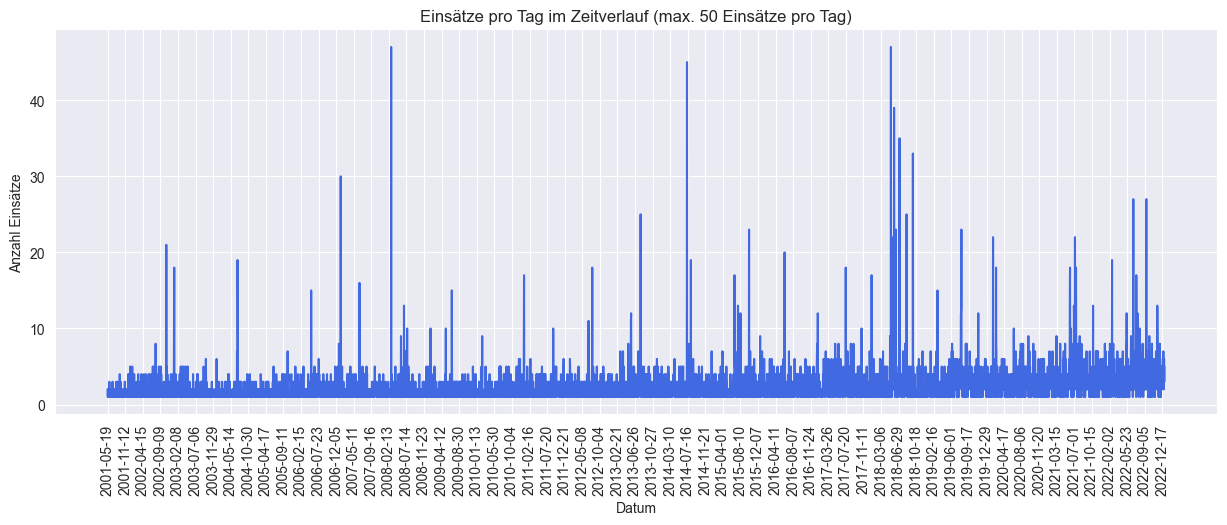

In [24]:
# Plot Anzahl Einsätze pro Tag reduziert als Linechart, mit Titel und Labels, x-Achse als Jahr_Monat_Tag um 90° drehen, 
# nur jedes 100. Label anzeigen
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Tag im Zeitverlauf (max. 50 Einsätze pro Tag)")
plt.xlabel("Datum")
plt.ylabel("Anzahl Einsätze")
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(df_einsätze_tag_max_50["Jahr_Monat_Tag"]), 100))
plt.plot(df_einsätze_tag_max_50["Jahr_Monat_Tag"], df_einsätze_tag_max_50["Anzahl"], color=color)
plt.savefig("./Plots/einsaetze_pro_tag_im_zeitverlauf_max_50.png")

Auch hier ist ein steigender Trend erkennbar.

In [25]:
# Letztes Jahr ermitteln
letztes_jahr = df["Jahr"].max() - 1

print("Summe aller Einsätze:", df["Nr"].count())   # Summe aller Einsätze
print()

print("Durchschnitt der Einsätze pro Jahr:", np.round(df["Jahr"].value_counts().mean(), 2))    # Durchnitt der Einsätze pro Jahr
print("Einsätze im letzten Jahr:", df[df["Jahr"] == letztes_jahr]["Nr"].count())  # Einsätze im letzten Jahr
print()

# Durchschnitt der Einsätze pro Monat
print("Durchschnitt der Einsätze pro Monat:", np.round(df["Nr"].count() / (df["Monat"].nunique() * df["Jahr"].nunique()), 2))
# Durchschnitt der Einsätze pro Monat im letzten Jahr
print("Durchschnitt der Einsätze pro Monat im letzten Jahr:", np.round(df[df["Jahr"] == letztes_jahr]["Nr"].count() / df["Monat"].nunique(), 2))
print()

# Durchschnitt der Einsätze pro Tag, wenn Jahr 365 Tage hat
print("Durchschnitt der Einsätze pro Tag:", np.round(np.round(df["Jahr"].value_counts().mean(), 2) / 365, 2))
# Durchschnitt der Einsätze pro Tag im letzten Jahr, wenn Jahr 365 Tage hat
print("Durchschnitt der Einsätze pro Tag im letzten Jahr:", np.round(df[df["Jahr"] == letztes_jahr]["Nr"].count() / 365, 2))

Summe aller Einsätze: 15440

Durchschnitt der Einsätze pro Jahr: 701.82
Einsätze im letzten Jahr: 1301

Durchschnitt der Einsätze pro Monat: 58.48
Durchschnitt der Einsätze pro Monat im letzten Jahr: 108.42

Durchschnitt der Einsätze pro Tag: 1.92
Durchschnitt der Einsätze pro Tag im letzten Jahr: 3.56


### Einsätze nach Einsatztyp

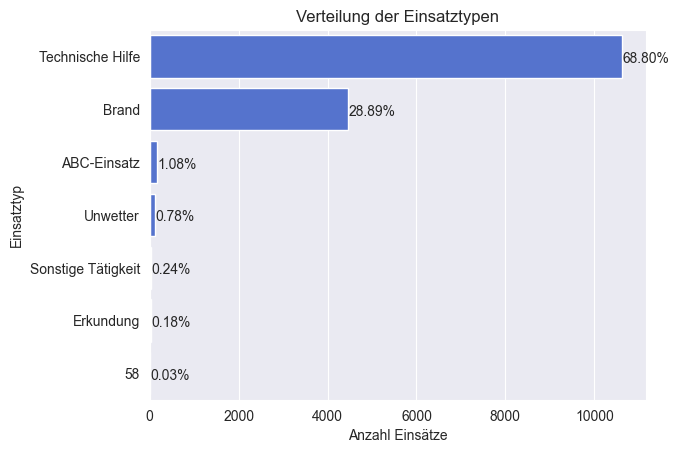

In [26]:
# Plot Verteilung der Einsatztypen, sortiert nach Häufigkeit, mit Titel und Prozent Werte hinter den Balken
plt.title("Verteilung der Einsatztypen")
sns.countplot(y="Einsatztyp", data=df, order=df["Einsatztyp"].value_counts().index, color=color)
for p in plt.gca().patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}%'.format(100*width/df.shape[0]),
             va='center')
plt.xlabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_einsatztyp.png")

1. ca. 2/3 THL
2. ca. 1/3 Brand
- Der Rest ist zu vernachlässigen

Tableau

![Einsatztypen](./Plots/Tableau/einsatztypen.png "Einsatztypen")

In [27]:
anzeigen = ["Technische Hilfe", "Brand", "ABC-Einsatz"] # Liste mit den Einsatztypen, die angezeigt werden sollen

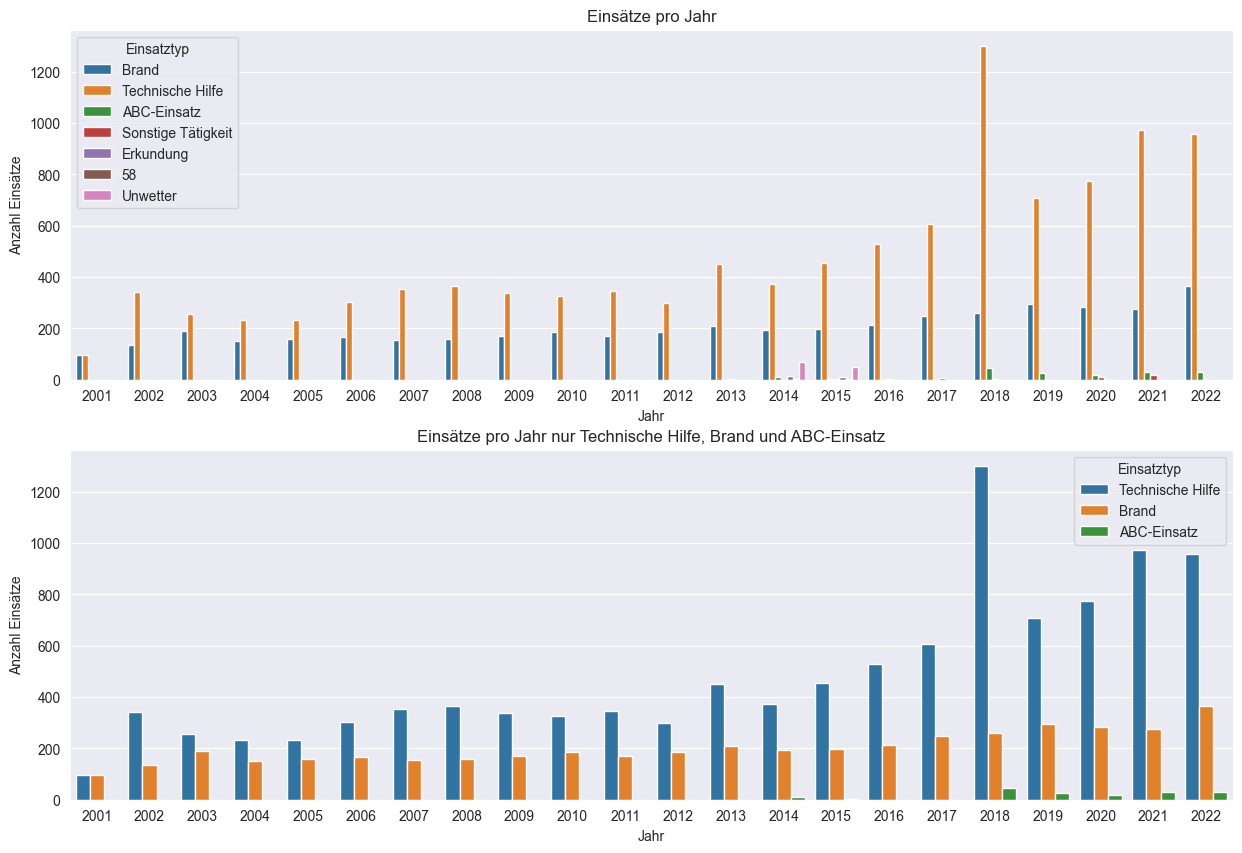

In [28]:
# Plot mit zwei subplots 
# 1. Summe der Einsätze pro Jahr, sortiert nach Jahr, aufgeteilt nach Einsatztyp, mit Titel und Labels
# 2. Summe der Einsätze pro Jahr, sortiert nach Jahr, aufgeteilt nach Einsatztyp, mit Titel und Labels, kleinere Auswahl
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.set_title("Einsätze pro Jahr")
sns.countplot(x="Jahr", hue="Einsatztyp", data=df, order=df["Jahr"].value_counts().sort_index().index, ax=ax1)
ax1.set_xlabel("Jahr")
ax1.set_ylabel("Anzahl Einsätze")

ax2.set_title("Einsätze pro Jahr nur Technische Hilfe, Brand und ABC-Einsatz")
sns.countplot(x="Jahr", hue="Einsatztyp", data=df, order=df["Jahr"].value_counts().sort_index().index, hue_order=anzeigen, 
    ax=ax2)
ax2.set_xlabel("Jahr")
ax2.set_ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_jahr_nach_einsatztyp.png")

- Trend:
  - THL steigt deutlich
  - Brand steigt leicht
- 2018 THL, klarer Ausreißer
- Ab 2014 auch ABC-Einsätze, ab 2018 deutlicher erkennbar
- Sonstige Tätigkeiten, Erkundung, 58 und Unwetter sind zu vernachlässigen

In [29]:
# Berechne das Verhältnis für jeden Einsatztyp und Jahr und speichere es in neuem DataFrame
df_einsätze_prozent = pd.DataFrame()
for typ in df["Einsatztyp"].unique():
    for jahr in df["Jahr"].unique():
        df_einsätze_prozent = df_einsätze_prozent.append({"Jahr": jahr, "Einsatztyp": typ, "Prozent": np.round(df[(df["Jahr"] == jahr) & 
            (df["Einsatztyp"] == typ)]["Nr"].count() / df[df["Jahr"] == jahr]["Nr"].count(), 2)}, ignore_index=True)

# Sortiere nach Jahr
df_einsätze_prozent.sort_values(by="Jahr", inplace=True)

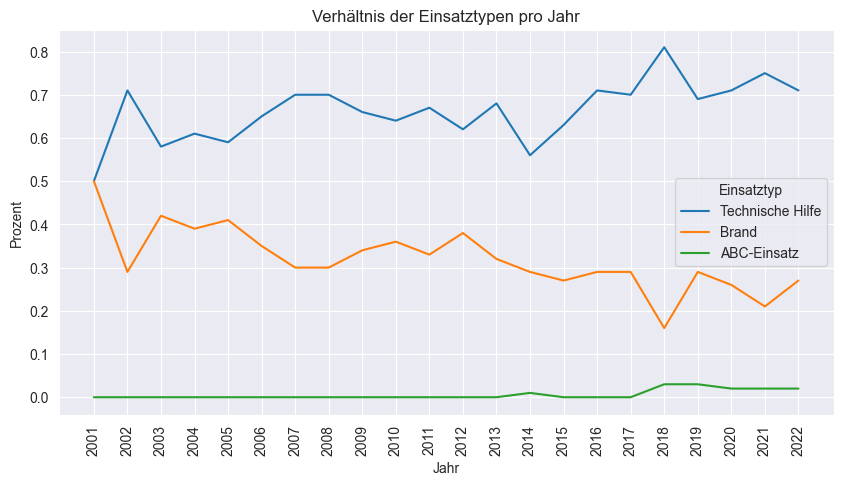

In [30]:
# Plot die Verhältnisse, mit Titel und Labels, x-Achse als Jahr, alle Labels anzeigen um 90° drehen, y-Achse von 0 bis 1
plt.figure(figsize=(10, 5))
plt.title("Verhältnis der Einsatztypen pro Jahr")
plt.xlabel("Jahr")
plt.ylabel("Prozent")
plt.xticks(rotation=90)
plt.xticks(df_einsätze_prozent["Jahr"].unique())
plt.yticks(np.arange(0, 1.1, 0.1))
sns.lineplot(x="Jahr", y="Prozent", hue="Einsatztyp", data=df_einsätze_prozent, hue_order=anzeigen)
plt.savefig("./Plots/verhaeltnis_der_einsatztypen_pro_jahr.png")

Alles im Verhältnis betrachten:
- THL nimmt leicht zu
- Brand nimmt leicht ab
- ABC-Einsatz nimmt leicht zu

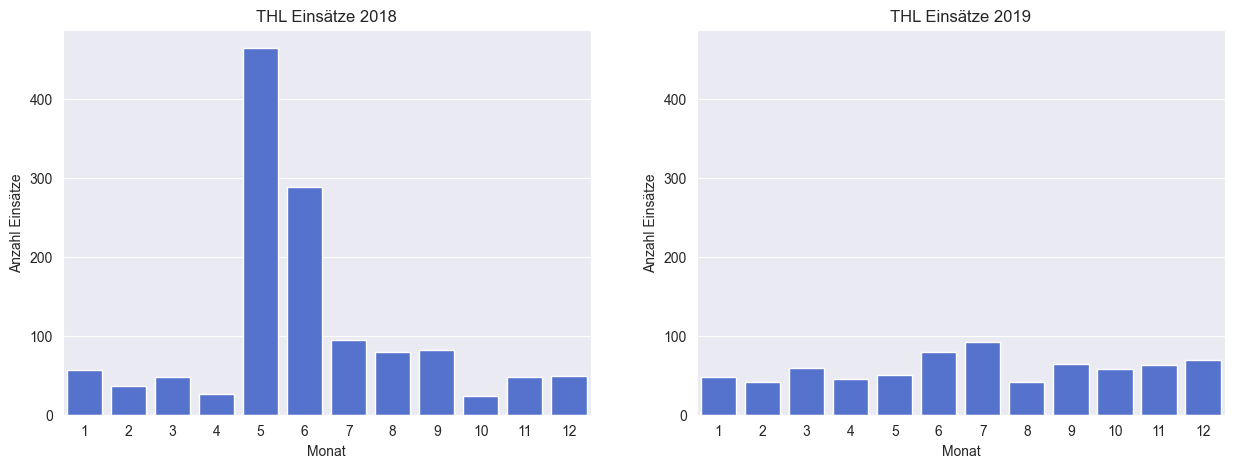

In [31]:
# Plot mit zwei subplots 
# 1. Plot Verteilung THL Einsätze 2018 über die Monate, sortiert nach Monat, mit Titel und Labels
# 2. Plot Verteilung THL Einsätze 2019 über die Monate, sortiert nach Monat, mit Titel und Labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("THL Einsätze 2018")
sns.countplot(x="Monat", data=df[(df["Jahr"] == 2018) & (df["Einsatztyp"] == "Technische Hilfe")], 
                order=df["Monat"].value_counts().sort_index().index, ax=ax1, color=color)
ax1.set_xlabel("Monat")
ax1.set_ylabel("Anzahl Einsätze")

ax2.set_ylim(ax1.get_ylim())    # gleiche y-Achsenskalierung
ax2.set_title("THL Einsätze 2019")
sns.countplot(x="Monat", data=df[(df["Jahr"] == 2019) & (df["Einsatztyp"] == "Technische Hilfe")], 
                order=df["Monat"].value_counts().sort_index().index, ax=ax2, color=color)
ax2.set_xlabel("Monat")
ax2.set_ylabel("Anzahl Einsätze")
plt.savefig("./Plots/thl_einsaetze_pro_monat_2018_2019.png")

- Mai und Juni 2018 extrem viele Alamierungen THL (THL, Unwetter, Gewitter, Starkregen, Keller unter Wasser)
- In den Daten: Alle paar Minuten oder auch zeitgleich eine Alarmierung
- Eventuell ein Fehler bei der Datenerfassung
  - Webseite und meine Daten stimmen überein
  - Datenerfassung stimmt
  - Bei Alarmierung ein Fehler?
- Mai und Juni, war Unwetterzeit in Unterfranken

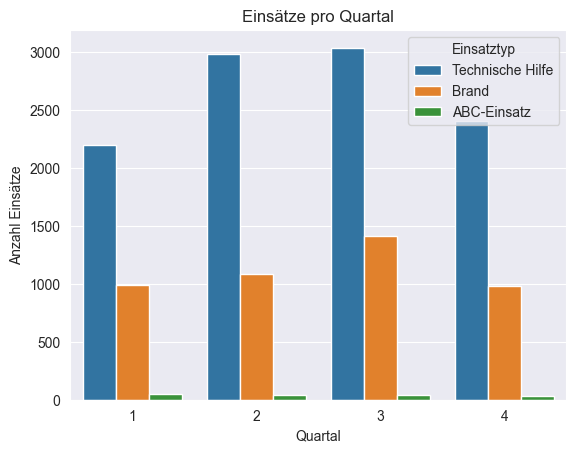

In [32]:
# Plot Summe der Einsätze pro Quartal, aus Alarmierungszeit, sortiert nach Quartal, mit Titel und Labels, unterteilt nach Einsatztypen
plt.title("Einsätze pro Quartal")
sns.countplot(x=pd.to_datetime(df["Alarmierungszeit"]).dt.quarter, hue="Einsatztyp", data=df,
                hue_order=anzeigen, order=pd.to_datetime(df["Alarmierungszeit"]).dt.quarter.value_counts().sort_index().index)
plt.xlabel("Quartal")
plt.ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_quartal_nach_einsatztyp.png")

- THL in Quartal 2 und 3 ca. gleich auf
- Brand im Quartal 3 am höchsten

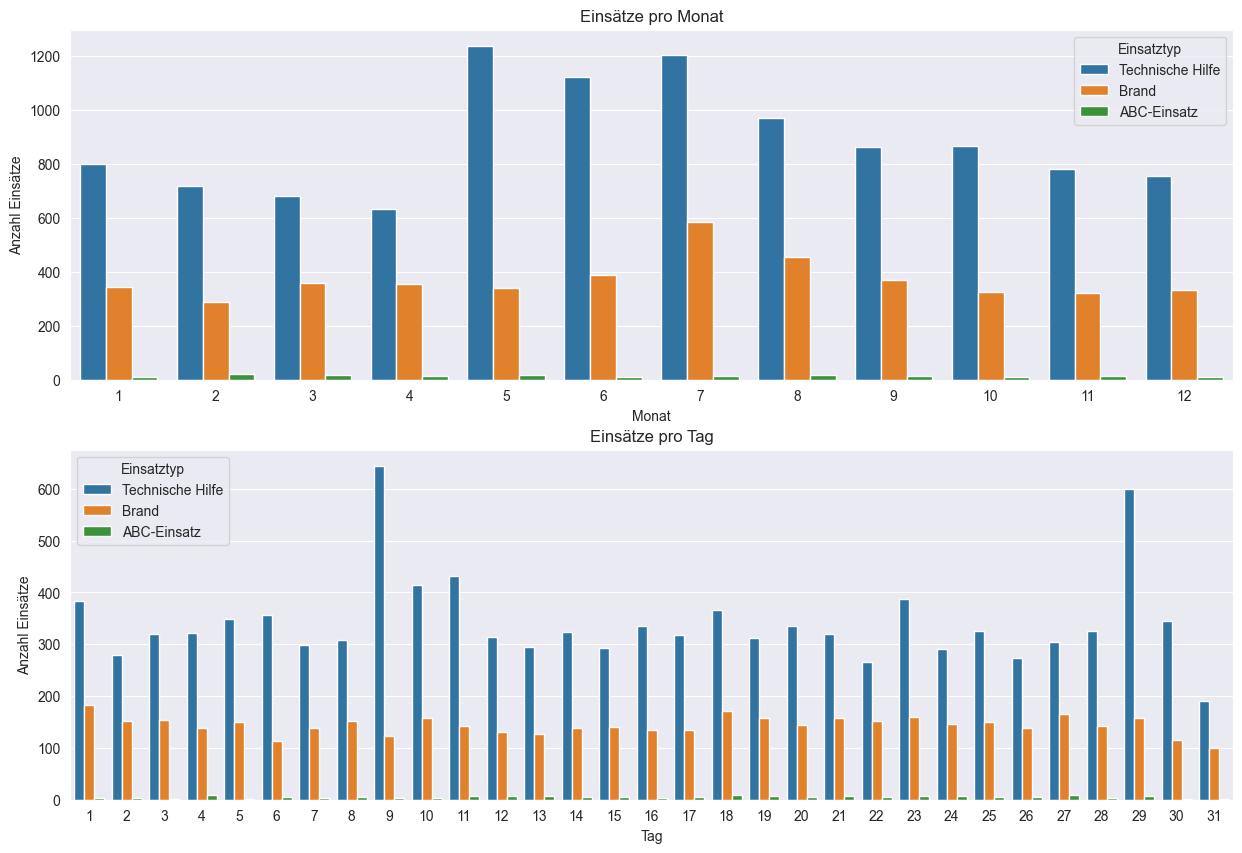

In [33]:
# Plot mit zwei subplots
# 1. Summe der Einsätze pro Monat, sortiert nach Monat, mit Titel und Labels
# 2. Summe der Einsätze pro Tag, sortiert nach Tag, mit Titel und Labels
# Unterteilt nach Einsatztyp, nur Technische Hilfe, Brand und ABC
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.set_title("Einsätze pro Monat")
sns.countplot(x="Monat", hue="Einsatztyp", data=df, order=df["Monat"].value_counts().sort_index().index, ax=ax1, 
    hue_order=anzeigen)
ax1.set_xlabel("Monat")
ax1.set_ylabel("Anzahl Einsätze")

ax2.set_title("Einsätze pro Tag")
sns.countplot(x="Tag", hue="Einsatztyp", data=df, order=df["Tag"].value_counts().sort_index().index, ax=ax2, 
    hue_order=anzeigen)
ax2.set_xlabel("Tag")
ax2.set_ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_monat_und_tag_nach_einsatztyp.png")

- Monatlich:
  - THL und Brand im Sommer mehr als im Winter
- Täglich:
  - THL Tag 9 und Tag 29 stechen klar heraus
  - THL, Brand und ABC-Einsatz relativ stabil

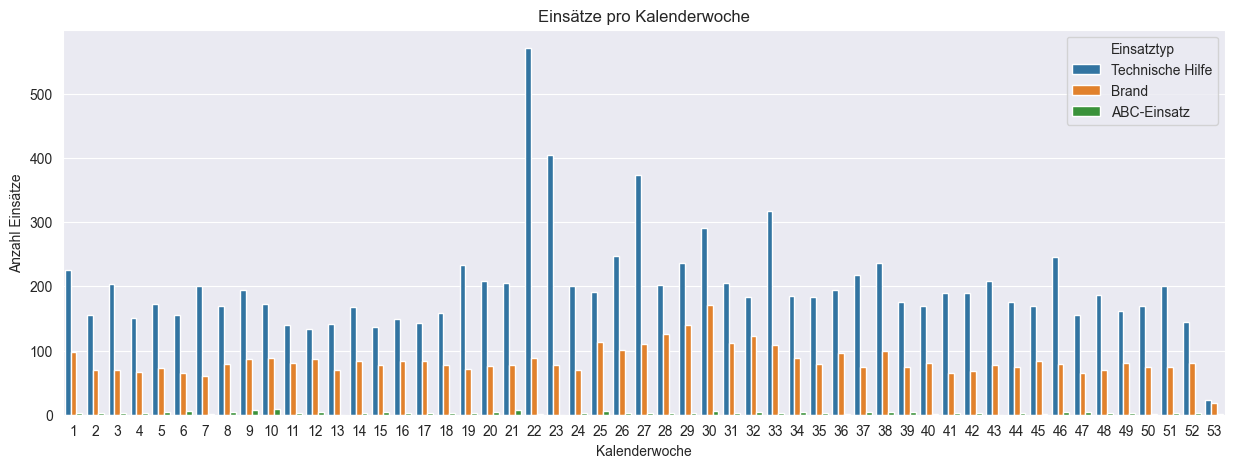

In [34]:
# Plot Summe der Einsätze pro Kalenderwoche, sortiert nach Kalenderwoche, mit Titel und Labels
plt.figure(figsize=(15, 5))
plt.title("Einsätze pro Kalenderwoche")
sns.countplot(x="Kalenderwoche", data=df, order=df["Kalenderwoche"].value_counts().sort_index().index,
              hue="Einsatztyp", hue_order=anzeigen)
plt.xlabel("Kalenderwoche")
plt.ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_kalenderwoche_nach_einsatztyp.png")

- Brand steigt im Sommer deutlich an
- THL nimmt ebenfalls im Sommer leicht zu
- Ausreißer wurden bereits oben genannt

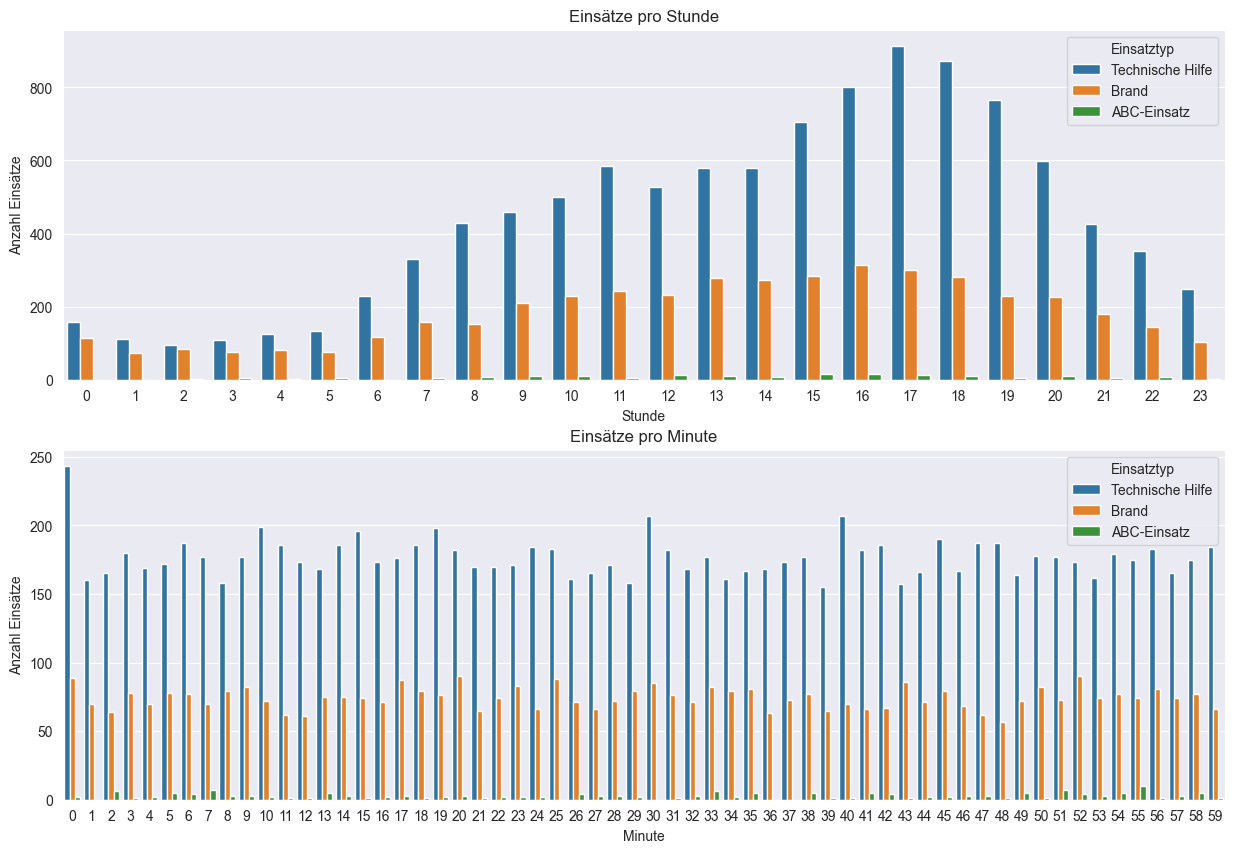

In [35]:
# Plot mit zwei subplots
# 1. Summe der Einsätze pro Stunde, sortiert nach Stunde, mit Titel und Labels
# 2. Summe der Einsätze pro Minute, sortiert nach Minute, mit Titel und Labels 
# Unterteilt nach Einsatztyp, nur Technische Hilfe, Brand und ABC
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.set_title("Einsätze pro Stunde")
sns.countplot(x="Stunde", hue="Einsatztyp", data=df, order=df["Stunde"].value_counts().sort_index().index, ax=ax1,
    hue_order=anzeigen)
ax1.set_xlabel("Stunde")
ax1.set_ylabel("Anzahl Einsätze")

ax2.set_title("Einsätze pro Minute")
sns.countplot(x="Minute", hue="Einsatztyp", data=df, order=df["Minute"].value_counts().sort_index().index, ax=ax2,
    hue_order=anzeigen)
ax2.set_xlabel("Minute")
ax2.set_ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_stunde_und_minute_nach_einsatztyp.png")

- Gleiche Sesionalität bei den Stunden, wie bereits oben beschrieben, steigt bis Nachmittag / Abends an und nimmt anschließend wieder ab
- Minuten relativ gleich verteilt, einziger Ausreißer bei Minute 0, vorallem THL
- Kein unterschiedliches Verhalten zwischen den Einsatztypen

In [36]:
# Summe der Einsätze für jedes Quartal nach Einsatztyp unterteilt
df_einsätze_pro_quartal = df.groupby(["Jahr", pd.to_datetime(df["Alarmierungszeit"]).dt.quarter, "Einsatztyp"]).size().reset_index(name="Anzahl")

# Label aus Jahr und Quartal erstellen
df_einsätze_pro_quartal["Jahr_Quartal"] = df_einsätze_pro_quartal["Jahr"].astype(str) + "-" + \
                                          df_einsätze_pro_quartal["Alarmierungszeit"].astype(str)

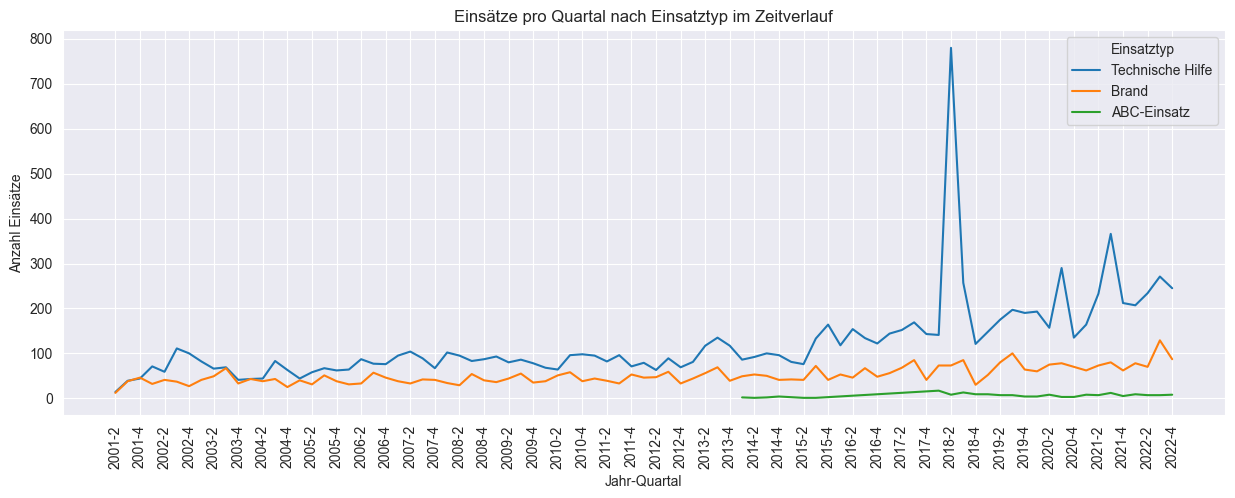

In [37]:
# Plot Einsätze pro Quartal nach Einsatztyp im Zeitverlauf, nur jedes zweite Label anzeigen
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="Jahr_Quartal", y="Anzahl", hue="Einsatztyp", data=df_einsätze_pro_quartal, hue_order=anzeigen)
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Einsätze pro Quartal nach Einsatztyp im Zeitverlauf")
ax.set_xlabel("Jahr-Quartal")
ax.set_ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_quartal_nach_einsatztyp_im_zeitverlauf.png")

- ABC-Einsätze ab 2014
- Ausreißer THL
  - 2018
  - 2020
  - 2021
- Steigender Trend auch hier erkennbar, vorallem bei THL

In [38]:
# Summe der Einsätze für jeden Monat aller Jahre nach Einsatztyp unterteilt, speichern in neuem DataFrame
df_einsätze_monat_typ = df.groupby(["Jahr", "Monat", "Einsatztyp"]).size().reset_index(name="Anzahl")

# Label aus Jahr und Monat erstellen
df_einsätze_monat_typ["Jahr_Monat"] = df_einsätze_monat_typ["Jahr"].astype(str) + "-" + \
                                      df_einsätze_monat_typ["Monat"].astype(str).str.zfill(2)

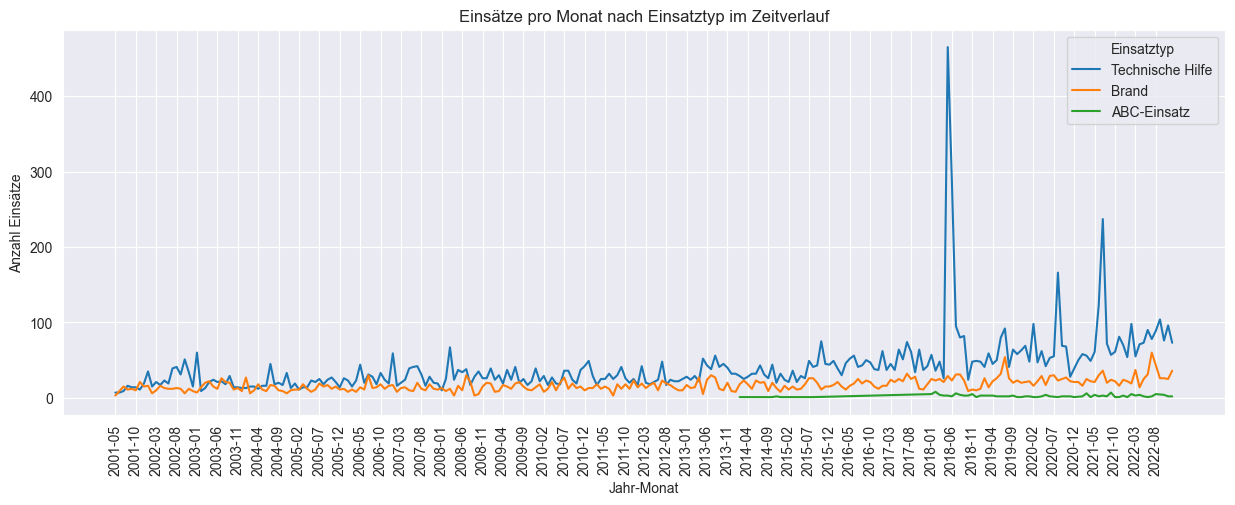

In [39]:
# Plot Anzahl als Linechart für alle Jahr_Monat, mit Titel und Labels, x-Achse als Jahr_Monat um 90° drehen, nur jedes fünfte Label anzeigen
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="Jahr_Monat", y="Anzahl", hue="Einsatztyp", data=df_einsätze_monat_typ, ax=ax, hue_order=anzeigen)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Einsätze pro Monat nach Einsatztyp im Zeitverlauf")
ax.set_xlabel("Jahr-Monat")
ax.set_ylabel("Anzahl Einsätze")
plt.savefig("./Plots/einsaetze_pro_monat_nach_einsatztyp_im_zeitverlauf.png")

- ABC-Einsätze ab 2014
- Ausreißer THL
  - 2018
  - 2020
  - 2021
- Steigender Trend auch hier erkennbar, vorallem bei THL
- Ähnliches Bild wie bei Einsätze pro Quartal

### Einsätze nach Einsatzort

In [40]:
# Verteilung der Einsätze pro Ort, sortiert nach Anzahl und nur größer als 100
df["Einsatzort"].value_counts().sort_values(ascending=False)[df["Einsatzort"].value_counts().sort_values(ascending=False) > 100].shape

(34,)

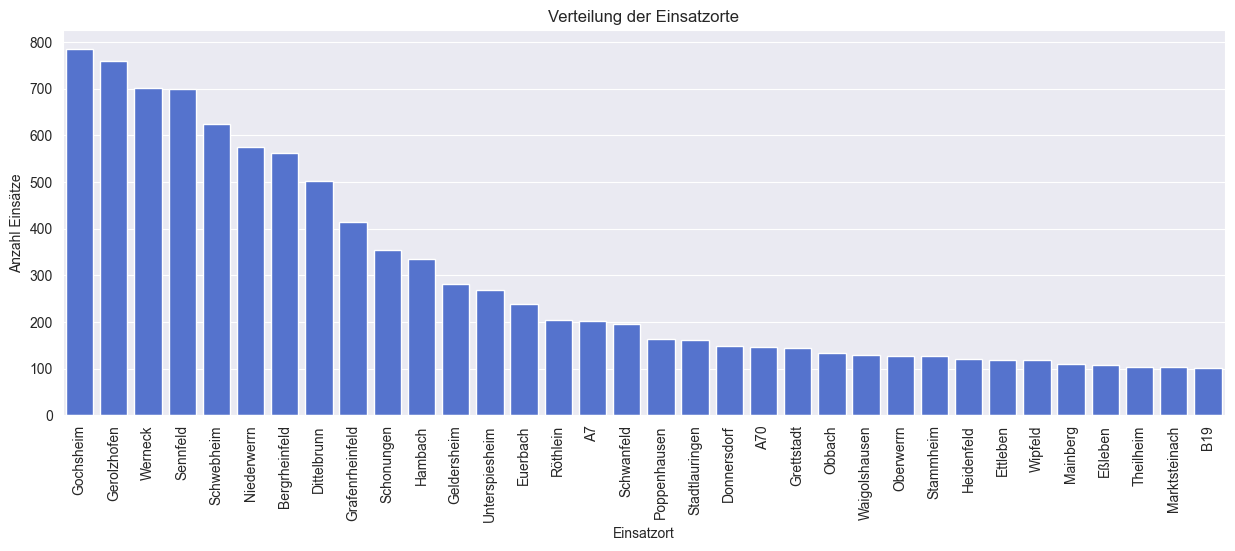

In [41]:
# Plot Verteilung der Einsatzorte, sortiert nach Häufigkeit
plt.figure(figsize=(15, 5))
plt.title("Verteilung der Einsatzorte")
plt.xticks(rotation=90)
sns.countplot(x="Einsatzort", data=df, order=df["Einsatzort"].value_counts().sort_values(ascending=False)
    [df["Einsatzort"].value_counts().sort_values(ascending=False) > 100].index, color=color)
plt.ylabel("Anzahl Einsätze")
plt.savefig("./Plots/verteilung_der_einsatzorte.png")

- In größeren Orten sind mehr Einsätze

In [42]:
# Heatmap der Einsatzorte
# Erstelle Grundkarte mit Zentrum aus den Mittelwerten der Breitengrade und Längengrade
mapObj = folium.Map(location = [df["Breitengrad"].mean(), df["Längengrad"].mean()], zoom_start = 10)

# erstelle Heatmap, drop NaN
HeatMap(data = df[["Breitengrad", "Längengrad"]].dropna(axis = 0, how = "any"), radius = 15).add_to(mapObj)

# speichere Karte
mapObj.save("./Plots/heatmap_einsatzorte.html")
mapObj

Heatmap entspricht nicht 100% der Wirklichkeit.
- Nur Orte im Landkreis Schweinfurt dargestellt
- Autobahnen, Bundesstraßen, ... nicht betrachtet, da genaue Positon nicht bekannt ist
- Bibliothek welche die Längen- und Breitengrade ermittelt, ist nicht 100%ig korrekt
- In den größeren Orten mehr Einsätze

### Einsätze nach Organisationen

In [43]:
# Verteilung der einzelnen Organisationen aus Spalte Organisationen_Liste, sortiert nach Anzahl
df["Organisationen_Liste"].explode().value_counts().sort_values(ascending=False).shape

(472,)

In [44]:
# Verteilung der einzelnen Organisationen aus Spalte Organisationen_Liste, sortiert nach Anzahl, nur größer als 200
organisationen_liste_200 = df["Organisationen_Liste"].explode().value_counts().sort_values(ascending=False) \
                           [df["Organisationen_Liste"].explode().value_counts().sort_values(ascending=False) > 200]
organisationen_liste_200.shape

(27,)

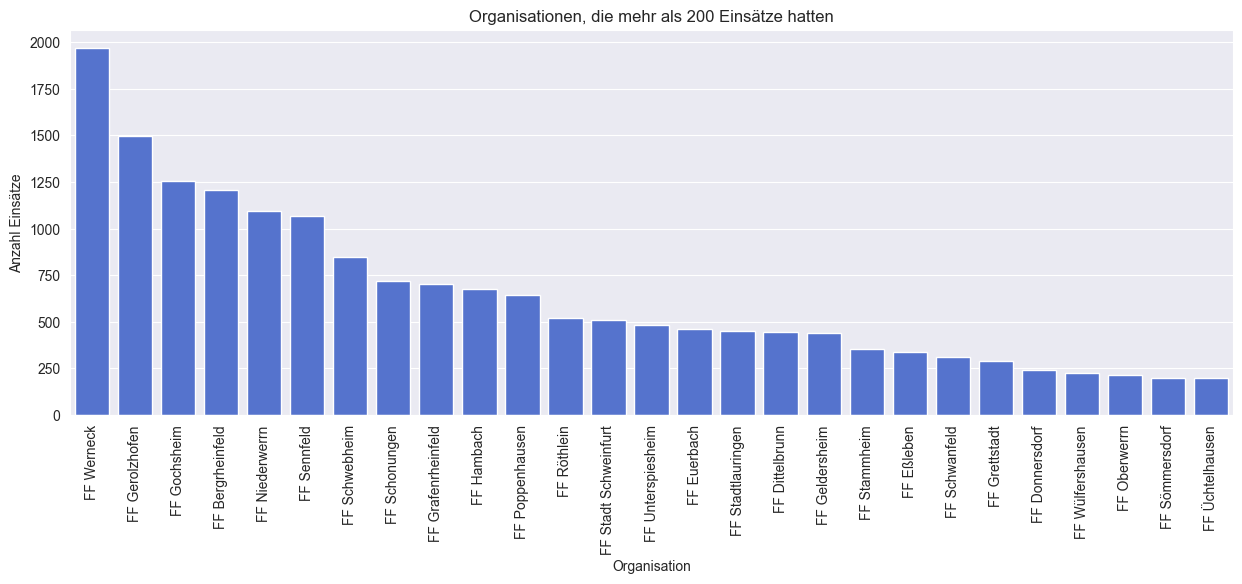

In [45]:
# Plot organisationen_liste_200, mit Titel und Labels
plt.figure(figsize=(15, 5))
plt.title("Organisationen, die mehr als 200 Einsätze hatten")
plt.xlabel("Organisation")
plt.ylabel("Anzahl Einsätze")
plt.xticks(rotation=90)
sns.barplot(x=organisationen_liste_200.index, y=organisationen_liste_200.values, color=color)
plt.savefig("./Plots/organisationen_mehr_als_200_einsaetze.png")

- Größere Feuerwehren, werden öfters alarmiert

In [46]:
# Print Top 5, wo Organisationen_Anzahl am größten, meisten Organisationen im Einsatz
# nur die Spalten: Nr, Alarmierungszeit, Wochentag, Einsatztyp, Einsatzort,	Kurzbericht, Organisationen, Organisationen_Anzahl
df[["Nr", "Alarmierungszeit", "Wochentag", "Einsatztyp", "Einsatzort", "Kurzbericht", "Organisationen", "Organisationen_Anzahl"]] \
    .nlargest(5, "Organisationen_Anzahl")

,Nr,Alarmierungszeit,Wochentag,Einsatztyp,Einsatzort,Kurzbericht,Organisationen,Organisationen_Anzahl
3502,236,2020-03-21 08:00:00,Saturday,Technische Hilfe,Innenstadt,THL allgemein,FF Frankenwinheim;FF Gochsheim;FF Weyer;FF Nie...,49
621,731,2022-07-28 13:26:00,Thursday,Brand,Langendorf,Alarmstufenerhöhung auf B4,FF Oberwerrn;FF Hammelburg (KG);FF Reiterswies...,29
10990,36,2011-01-09 10:00:00,Sunday,Brand,Lkr. Schweinfurt,Hochwasser in verschiedenen Ortschaften (alarm...,FF Bergrheinfeld;FF Eckartshausen;FF Egenhause...,28
54,1298,2022-12-17 19:27:00,Saturday,Brand,Ebertshausen,Alarmstufenerhöhung auf B4,FF Werneck;FL Schweinfurt-Land 2/4;UG-ÖEL Schw...,26
1102,250,2022-03-18 11:09:00,Friday,Brand,Karbach,Brand Stall / Scheune,FF Michelau;FF Untersteinbach (HAS);FF Prölsdo...,26


- In den Top 5, vier mal Brand
- Eine unlogische Zuordnung bei Alarmierungszeit 2011-01-09 10:00:00
  - Kurzbericht: Hochwasser
  - Einsatztyp: Brand

In [47]:
# aus Organisationen_Liste eine Liste mit allen Organisationen erstellen und in ein DataFrame umwandeln
df_organisationen = pd.DataFrame(df["Organisationen_Liste"].explode().unique().tolist(), columns=["Organisation"])

# bei df_organisationen eine Spalte hinzufügen, die nur die Organisationstyp enthält
df_organisationen["Organisationstyp"] = df_organisationen["Organisation"].str.split(" ").str[0]

# bei df_organisationen eine Spalte hinzufügen, die nur die Ortsbezeichnung enthält
df_organisationen["Ort"] = df_organisationen["Organisation"].str.split(" ").str[1]

# füge df_orgaisationen zwei Spalten mit Längen- und Breitengraden hinzu, Daten aus df, einsatzort = ort
df_organisationen = df_organisationen.merge(df[["Einsatzort", "Breitengrad", "Längengrad"]].drop_duplicates(), left_on="Ort", right_on="Einsatzort")

# Spalte Einsatzort löschen
df_organisationen.drop("Einsatzort", axis=1, inplace=True)

In [48]:
# Heatmap der Organisationen, von df_organisationen
# erstelle Grundkarte mit Zentrum aus den Mittelwerten der Breitengrade und Längengrade
mapObj = folium.Map(location = [df_organisationen["Breitengrad"].dropna(axis = 0, how = "any").mean() + 0.3, 
    df_organisationen["Längengrad"].dropna(axis = 0, how = "any").mean()], zoom_start = 10)

# erstelle Heatmap, drop NaN
HeatMap(data = df_organisationen[["Breitengrad", "Längengrad"]].dropna(axis = 0, how = "any"), radius = 15).add_to(mapObj)

# speichere Karte
mapObj.save("./Plots/heatmap_organisationen.html")
mapObj

Heatmap entspricht nicht 100% der Wirklichkeit.
- Nur Orte im Landkreis Schweinfurt dargestellt
- Autobahnen, Bundesstraßen, ... nicht betrachtet, da genaue Positon nicht bekannt ist
- Bibliothek welche die Längen- und Breitengrade ermittelt, ist nicht 100%ig korrekt
- Größere Feuerwehren, werden öfters alarmiert

### Einsätze und Bilder

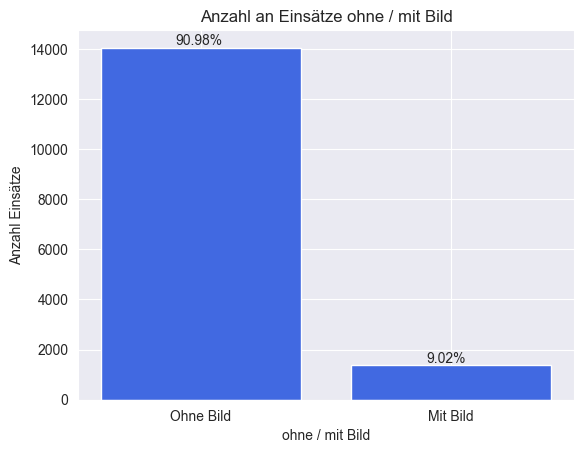

In [49]:
# Anzahl wo in Spalte Bilder die nopic.png ist und Anzahl in Spalte Bilder die nicht nopic.png sind, als bar chart
plt.title("Anzahl an Einsätze ohne / mit Bild")
plt.xlabel("ohne / mit Bild")
plt.ylabel("Anzahl Einsätze")
plt.bar(["Ohne Bild", "Mit Bild"], [df["Bild"].value_counts()[df["Bild"].value_counts().index == "nopic.png"].sum(),
                                    df["Bild"].value_counts()[df["Bild"].value_counts().index != "nopic.png"].sum()], color=color)

# Prozent als Text in bar chart
for i, v in enumerate([df["Bild"].value_counts()[df["Bild"].value_counts().index == "nopic.png"].sum(),
                                    df["Bild"].value_counts()[df["Bild"].value_counts().index != "nopic.png"].sum()]):
    plt.text(i - 0.1, v + 100, str(round(v / df.shape[0] * 100, 2)) + "%")

plt.savefig("./Plots/anzahl_einsaetze_ohne_mit_bild.png")

- Bei den meisten Einsätzen werden keine Bilder hochgeladen

In [50]:
# Anzahl Bilder pro Jahr, wenn Bild != "nopic.png"
series_bilder = df[df["Bild"] != "nopic.png"]["Jahr"].value_counts().sort_index()

# Fehlende Jahre mit Wert 0 anhängen
index = [2002, 2003, 2022]
series_bilder = series_bilder.append(pd.Series([0] * len(index), index=index)).sort_index()

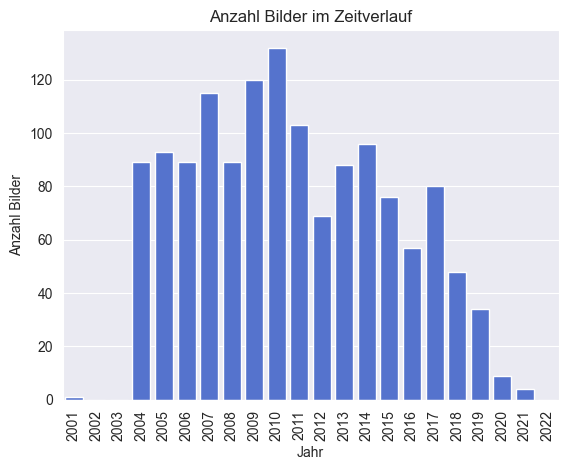

In [51]:
# Plot Anzahl Bilder im Zeitverlauf, sortiert nach Jahr, mit Titel und Labels
plt.title("Anzahl Bilder im Zeitverlauf")
plt.xlabel("Jahr")
plt.ylabel("Anzahl Bilder")
plt.xticks(rotation=90)
sns.barplot(x=series_bilder.index, y=series_bilder.values, color=color)
plt.savefig("./Plots/anzahl_bilder_zeitverlauf.png")

- Zuletzt ist ein fallender Trend erkennbar
- 2001, 2002 und 2003 wurden fast keine Bilder hochgeladen

### Einsätze nach Kurzbericht

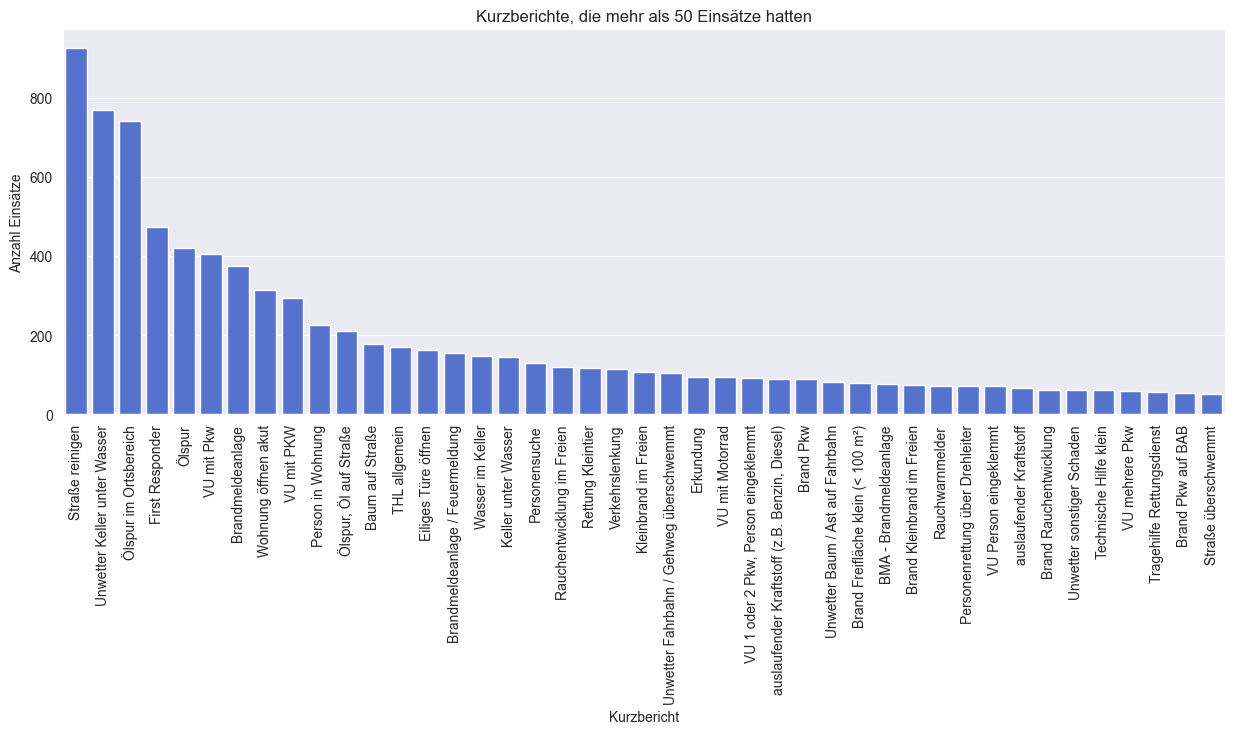

In [52]:
# Anzahl von Kurzberichten, wenn mehr als 50 mal vorkommt, mit Titel und Labels
plt.figure(figsize=(15, 5))
plt.title("Kurzberichte, die mehr als 50 Einsätze hatten")
plt.xlabel("Kurzbericht")
plt.ylabel("Anzahl Einsätze")
plt.xticks(rotation=90)
sns.barplot(x=df["Kurzbericht"].value_counts()[df["Kurzbericht"].value_counts() > 50].index,
            y=df["Kurzbericht"].value_counts()[df["Kurzbericht"].value_counts() > 50].values, color=color)
plt.savefig("./Plots/kurzberichte_mehr_als_50_einsaetze.png")

- Die häufigsten Einsätze
  - THL
  - Ungefährliche Einsätze

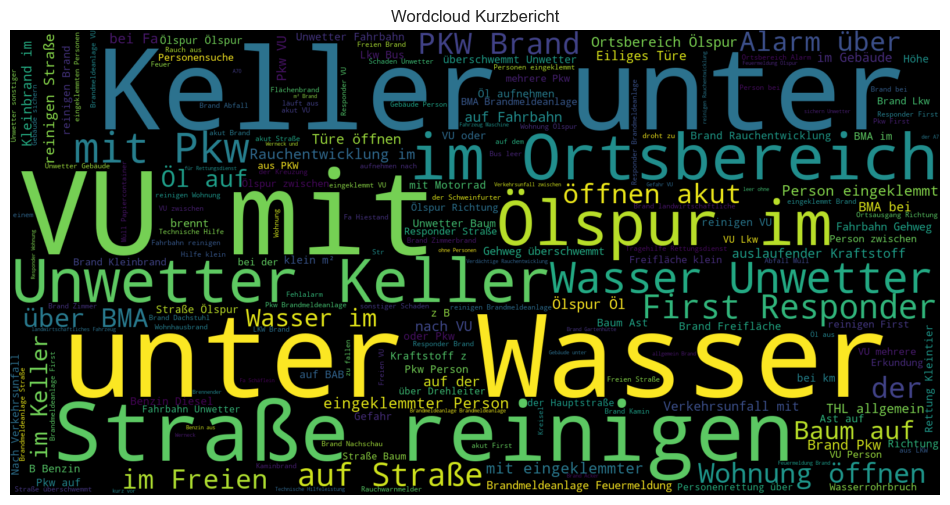

In [53]:
# Wordcloud von Kurzbericht, Kurzbericht in string umwandeln, wordcloud erstellen, mit Titel und Labels
text = " ".join(df["Kurzbericht"].astype(str))
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud Kurzbericht")
plt.savefig("./Plots/wordcloud_kurzbericht.png")